**Input Features:**
- Years of Experience: The number of years of experience required for the job, which has been processed to be a numeric value.
- Role: The job role (e.g., Developer, Senior, Manager). This is one-hot encoded into multiple binary columns, one for each role type.
- Additional features (optional): Other features in your dataset can be included, such as the company, job title, etc. But in your current example, only Years of Experience and Role are used for training the model.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

1. Load and Combine Data
Read CSV Files:
df is loaded from merged_data.csv.
new_data is loaded from merged_data2.csv.
Combine Data:
The datasets are concatenated using pd.concat().
Invalid rows (where Required Skills is NaN or empty) are removed using combined_data[~combined_data['Required Skills'].isna() & (combined_data['Required Skills'] != '')].
2. Data Parsing
Parsing Experience: The parse_experience function is applied to extract "Years of Experience" from text.
Parsing Salary: The parse_salary_range function is applied to compute a numerical salary value from a "Salary Range" column.
3. Outlier Removal
[Q1−1.5×IQR,Q3+1.5×IQR] are considered outliers and removed.
4. Handle Missing Values
Rows with missing values in Years of Experience or Salary are dropped using dropna().
5. Feature Transformation
Numeric Features:

- Years of Experience undergoes preprocessing:
Missing values are filled with the mean (SimpleImputer).
Polynomial features are generated with degree 2, creating interaction terms (PolynomialFeatures).
Categorical Features:

- Role, Level, and Location are preprocessed:
Missing values are replaced with the string 'missing'.
One-hot encoding is applied to convert categorical variables into binary columns.
Preprocessor: A ColumnTransformer is used to apply numeric and categorical transformations.

6. Model Pipeline
A pipeline is created to:
Apply preprocessing (preprocessor).
Train a linear regression model (LinearRegression).
7. Train-Test Split
The combined dataset is split into training (80%) and testing (20%) sets using train_test_split().
8. Train and Predict
Model Training: The pipeline is fitted on X_train (features) and y_train (target salary).
Prediction: Predictions are generated for the test set (X_test).
9. Model Evaluation
R² Score: The coefficient of determination (
𝑅
2
R
2
 ) is computed to measure model performance, indicating how well the regression predictions fit the data. A higher score implies better performance.
Output
The updated model's
𝑅
2
R
2
  score is printed to show the evaluation result of the trained model on the test data.

In [ ]:
# Parsing functions
def parse_experience(x):
    x = str(x)
    if '-' in x:
        low, high = x.split('-')
        return (float(low) + float(high)) / 2
    return float(x)

def parse_salary_range(s):
    s = str(s).lower().replace('$', '').strip()
    if '-' in s:
        low, high = s.split('-')
        return (float(low) + float(high)) / 2
    elif s.isdigit():
        return float(s)
    else:
        return np.nan

# Load original and new data
df = pd.read_csv('/content/merged_data.csv')
new_data = pd.read_csv('/content/merged_data2.csv')

combined_data = pd.concat([df, new_data], ignore_index=True)
combined_data = combined_data[~combined_data['Required Skills'].isna() & (combined_data['Required Skills'] != '')]


# combined_data = combined_data.drop_duplicates()
combined_data.to_csv('drop_duplicated.csv')

# Apply the parsing functions
combined_data['Years of Experience'] = combined_data['Years of Experience'].apply(parse_experience)
combined_data['Salary'] = combined_data['Salary Range'].apply(parse_salary_range)

# Remove potential outliers
Q1 = combined_data['Salary'].quantile(0.25)
Q3 = combined_data['Salary'].quantile(0.75)
IQR = Q3 - Q1
combined_data = combined_data[
    (combined_data['Salary'] >= Q1 - 1.5 * IQR) &
    (combined_data['Salary'] <= Q3 + 1.5 * IQR)
]

# Drop missing values
combined_data = combined_data.dropna(subset=['Years of Experience', 'Salary'])

# Define numeric and categorical features
numeric_features = ['Years of Experience']
categorical_features = ['Role', 'Level', 'Location']

# Preprocessing steps
numeric_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

def tokenize_required_skills(x):
    return x.split(',')

# Preprocess Required Skills
required_skills_transformer = Pipeline(steps=[
    ('vectorizer', CountVectorizer(tokenizer=tokenize_required_skills, lowercase=True))
])

# Update the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('skills', required_skills_transformer, 'Required Skills')  # Add this line
    ])

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Features and target variable
X_combined = combined_data[['Years of Experience', 'Role', 'Level', 'Location', 'Required Skills']]
y_combined = combined_data['Salary']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)
# Define parameter grid for GridSearchCV
param_grid = {
    'regressor__n_estimators': [400, 500, 600],
    'regressor__max_depth': [5, 20, None],
    'regressor__min_samples_split': [2, 5, 8],
    'regressor__min_samples_leaf': [1, 2, 4],
}

# Use the pipeline with the preprocessor and the regressor
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Best parameters and estimator
print(f'Best Parameters: {grid_search.best_params_}')
best_model = grid_search.best_estimator_

# Evaluate the best model
score = best_model.score(X_test, y_test)
print(f'Model R^2 Score: {score}')

# Test predictions
predictions = best_model.predict(X_test)
print("Predictions:", predictions[:5])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Best Parameters: {'regressor__max_depth': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 500}
Model R^2 Score: 0.7609695747641514
Predictions: [ 690.5242542   752.04997     927.48429    1651.22261     536.40491967]


# Calculate Metrics

- Error Metrics:
  + MSE: Average squared prediction error
  + MAE: Average absolute prediction error
  + RMSE: Square root of MSE, gives error in same units as target variable

- Variance Metrics:
  + Explained variance: Proportion of variance captured (0-1)
  + R²: Proportion of variance explained (-∞ to 1)
  + Adjusted R²: R² adjusted for number of predictors

In [ ]:
# Evaluate the best model

# Measures the average squared difference between the predicted values and the actual values.
# A lower MSE indicates a better fit of the model to the data.
mse = mean_squared_error(y_test, predictions)

# Measures the average absolute difference between the predicted and actual values.
mae = mean_absolute_error(y_test, predictions)

# Square root of the average squared differences between predictions and actual values.
rmse = np.sqrt(mse)

# Measures the proportion of the variance in the target variable that is captured by the model.
# Values range from 0 to 1 (higher is better).
explained_variance = explained_variance_score(y_test, predictions)

# Measures the proportion of variance in the dependent variable explained by the independent variables.
# Ranges from -inf to 1. (1 is perfect)
r2 = r2_score(y_test, predictions)

# Calculate Adjusted R² to account for the number of predictors in the model.
n = X_test.shape[0]  # Number of samples
p = X_test.shape[1]  # Number of predictors
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Evaluate the model metrics
metrics = {
    'Metric': ['Mean Squared Error (MSE)', 'Mean Absolute Error (MAE)', 'Root Mean Squared Error (RMSE)',
               'Explained Variance Score', 'R² Score', 'Adjusted R² Score'],
    'Value': [mse, mae, rmse, explained_variance, r2, adjusted_r2]
}

# Create a DataFrame for the metrics
metrics_df = pd.DataFrame(metrics)
metrics_df

,Metric,Value
0,Mean Squared Error (MSE),68615.365428
1,Mean Absolute Error (MAE),181.295767
2,Root Mean Squared Error (RMSE),261.945348
3,Explained Variance Score,0.767663
4,R² Score,0.760970
5,Adjusted R² Score,0.752612


Extracts and displays feature importance information from a trained model:

- Checks if model supports feature importances
- Gets preprocessor components for different feature types:

- Combines all feature names and their importance scores
- Creates sorted DataFrame showing most influential features

This helps identify which factors affect the model's predictions the most.

In [ ]:
if hasattr(best_model.named_steps['regressor'], 'feature_importances_'):
    feature_importances = best_model.named_steps['regressor'].feature_importances_

    # Access the transformers for numeric, categorical, and skills preprocessing
    preprocessor = best_model.named_steps['preprocessor']

    # Extract numeric feature names
    numeric_feature_names = numeric_features

    # Extract categorical feature names
    cat_transformer = preprocessor.transformers_[1][1].named_steps['onehot']
    categorical_feature_names = cat_transformer.get_feature_names_out(categorical_features).tolist()

    # Extract tokenized skill feature names
    skill_transformer = preprocessor.transformers_[2][1].named_steps['vectorizer']
    skill_feature_names = skill_transformer.get_feature_names_out().tolist()

    # Combine all feature names
    feature_names = numeric_feature_names + categorical_feature_names + skill_feature_names

    # Create a DataFrame for feature importance
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    print("Feature Importances:")
    print(feature_importance_df.head(10))


Feature Importances:
                          Feature  Importance
0             Years of Experience    0.115134
31                   Level_Junior    0.089120
510                       banking    0.017704
44   Location_Hà nội, Hồ Chí Minh    0.016860
38              Location_Bắc Ninh    0.015386
541                        devops    0.013167
73                       analysis    0.011400
30             Level_Intermediate    0.011240
276                      lãnh đạo    0.010524
43                Location_Hà nội    0.010047


# Visualize Metrics

<ipython-input-37-c2ad30a35962>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="viridis")


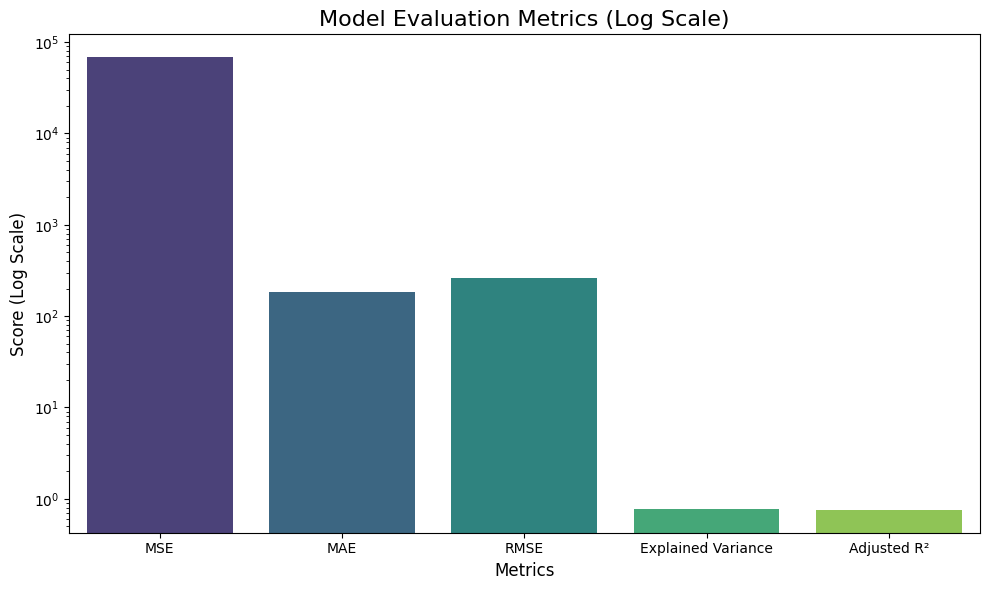

<ipython-input-37-c2ad30a35962>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


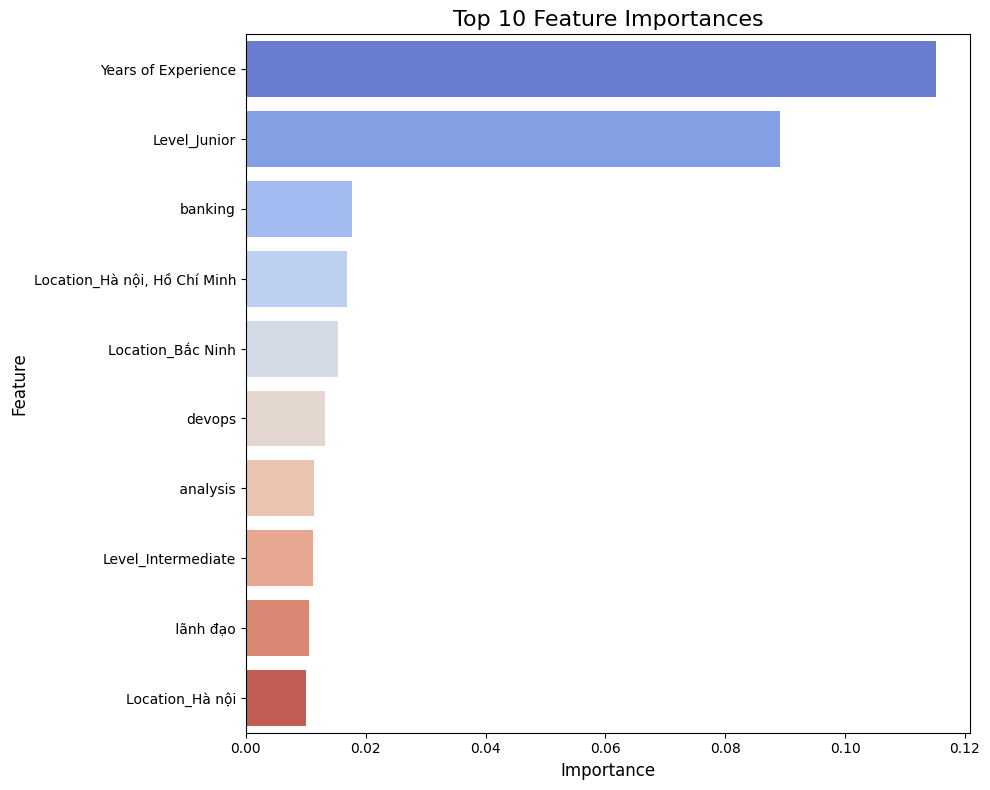

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Combine all metrics into one dictionary
metrics = {
    'MSE': mse,
    'MAE': mae,
    'RMSE': rmse,
    'Explained Variance': explained_variance,
    'Adjusted R²': adjusted_r2
}

# Create a bar chart with a logarithmic scale
plt.figure(figsize=(10, 6))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="viridis")
plt.yscale('log')  # Apply logarithmic scale to the y-axis
plt.title("Model Evaluation Metrics (Log Scale)", fontsize=16)
plt.ylabel("Score (Log Scale)", fontsize=12)
plt.xlabel("Metrics", fontsize=12)
plt.tight_layout()
plt.show()

# Visualization of Feature Importances (if available)
if 'feature_importance_df' in locals() or 'feature_importance_df' in globals():
    plt.figure(figsize=(10, 8))
    sns.barplot(
        data=feature_importance_df.head(10),
        y='Feature',
        x='Importance',
        palette="coolwarm"
    )
    plt.title("Top 10 Feature Importances", fontsize=16)
    plt.xlabel("Importance", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("Feature importances are not available for the chosen model.")

# Generate Data

- Data Structure:
  + Creates 150 total records (50 each for Junior/Intermediate/Senior)
  + Fields: Years of Experience, Role, Level, Required Skills, Location

- Key Components:
  + Experience ranges: Junior (1-2 years), Intermediate (3-5), Senior (5-15)
  + Roles: Data Engineer and Software Engineer
  + Predefined skill sets for each role/level combination
  + Locations: 5 major Vietnamese cities

- Data Generation Process:
  + Creates separate DataFrames for each level
  + Assigns random skills based on role/level
  + Randomly assigns Vietnamese cities
  + Combines all data into final_data DataFrame

In [ ]:
import numpy as np

# Define the categories for 'Role' and 'Level'
levels = ['Junior', 'Intermediate', 'Senior']

# Generate random data
num_samples = 50  # Number of samples per level

# Create data for each level
junior_data = {
    'Years of Experience': np.random.randint(1, 2, num_samples),
    'Role': 'data engineer',
    'Level': 'Junior'
}

intermediate_data = {
    'Years of Experience': np.random.randint(3, 5, num_samples),
    'Role': 'software engineer',
    'Level': 'Intermediate'
}

senior_data = {
    'Years of Experience': np.random.randint(5, 15, num_samples),
    'Role': 'data engineer',
    'Level': 'Senior'
}

import random

# Define skills for each role and level
skills_dict = {
    'data engineer': {
        'Junior': ['SQL', 'Python', 'Data Wrangling', 'Basic ETL', 'Data Analysis'],
        'Intermediate': ['Apache Spark', 'AWS', 'Data Pipelines', 'ETL', 'Data Modeling'],
        'Senior': ['Big Data', 'Cloud Architecture', 'Advanced ETL', 'Data Warehousing', 'System Design']
    },
    'software engineer': {
        'Junior': ['JavaScript', 'HTML', 'CSS', 'Python', 'Basic Web Development'],
        'Intermediate': ['React', 'Node.js', 'Full-Stack Development', 'REST APIs', 'Database Management'],
        'Senior': ['Microservices', 'System Design', 'DevOps', 'Cloud Computing', 'Distributed Systems']
    }
}

# Function to generate random skills for each sample based on role and level
def generate_skills(row):
    role = row['Role']
    level = row['Level']
    skills = skills_dict.get(role, {}).get(level, [])
    # Randomly select a subset of skills (up to 5 skills)
    return ', '.join(random.sample(skills, k=min(5, len(skills))))

# Define Vietnamese cities
vietnamese_cities = [
    'Hà Nội', 'Hồ Chí Minh', 'Đà Nẵng', 'Hải Phòng', 'Cần Thơ'
]

# Function to assign a random Vietnamese city
def assign_city():
    return random.choice(vietnamese_cities)

# Create DataFrames for each level
junior_df = pd.DataFrame(junior_data)
intermediate_df = pd.DataFrame(intermediate_data)
senior_df = pd.DataFrame(senior_data)

# Concatenate DataFrames
final_data = pd.concat([junior_df, intermediate_df, senior_df], ignore_index=True)

# Apply the function to generate required skills
final_data['Required Skills'] = final_data.apply(generate_skills, axis=1)

# Assign random Vietnamese cities to the 'Location' column
final_data['Location'] = final_data.apply(lambda _: assign_city(), axis=1)

# Display first few rows
print(final_data.head())

   Years of Experience           Role   Level  \
0                    1  data engineer  Junior   
1                    1  data engineer  Junior   
2                    1  data engineer  Junior   
3                    1  data engineer  Junior   
4                    1  data engineer  Junior   

                                     Required Skills   Location  
0  Data Wrangling, Data Analysis, Basic ETL, Pyth...    Đà Nẵng  
1  SQL, Data Wrangling, Python, Data Analysis, Ba...  Hải Phòng  
2  Data Wrangling, Python, Basic ETL, SQL, Data A...    Đà Nẵng  
3  Python, Basic ETL, Data Wrangling, SQL, Data A...  Hải Phòng  
4  Python, SQL, Data Wrangling, Basic ETL, Data A...    Đà Nẵng  


# Predict on generated data

In [ ]:
# Predict salaries using the trained model
predictions = best_model.predict(final_data)

# Add the predicted salaries to the new data
final_data['Predicted Salary'] = predictions
final_data.to_csv("predicted.csv")

# Save Model

In [ ]:
import joblib

# Save the LinearRegression model
joblib.dump(best_model, 'random_forest_regressor.pkl')

['random_forest_regressor.pkl']

# Use Model

## Load model REMEMBER TO CHANGE PATH

In [ ]:
import joblib

# Load the trained RandomForestRegressor model
model = joblib.load('/content/random_forest_regressor.pkl') #

## predict data

In [ ]:
predictions = model.predict(final_data)
# Show the predictions
print("Predictions for new data:", predictions)

Predictions for new data: [ 581.70255832  601.015948    581.70255832  558.60265026  558.60265026
  645.03338722  647.8342393   581.70255832  645.03338722  558.60265026
  572.1961998   645.03338722  647.8342393   647.8342393   638.85838434
  601.015948    558.60265026  601.015948    581.70255832  581.70255832
  638.85838434  581.70255832  572.1961998   558.60265026  581.70255832
  601.015948    581.70255832  581.70255832  581.70255832  581.70255832
  601.015948    572.1961998   558.60265026  581.70255832  612.32970114
  638.85838434  666.75135824  647.8342393   581.70255832  558.60265026
  601.015948    661.07087427  622.481143    601.015948    558.60265026
  581.70255832  661.07087427  558.60265026  645.03338722  581.70255832
 1212.67926666 1098.90697722 1118.09920225 1098.90697722 1098.90697722
 1099.24166574 1198.13239168 1211.7933075  1092.10139165 1211.02190131
 1211.02190131 1197.69924813 1210.78557694 1210.21846367 1098.90697722
 1210.78557694 1210.98986987 1087.97187609 1211.793